# Text Processing for Accelerator project

A simplified pipeline processing text with FastText.

* Load demo data - Film overviews/genres
* Basic text cleaning
* Vectorize (with FastText)
* Cluster (HDBSCAN)
* Evaluate
* Visualise

In [31]:
# this bit shouldn't be necessary if we pip install -e .   in the parent directory
%load_ext autoreload
%autoreload 2

In [117]:
import functools
from pprint import pprint
from time import time
from IPython.display import display, HTML
import logging
import pandas as pd
import numpy as np
import plotly.express

In [124]:
import text_processing

#### Load in the CPA data

In [125]:
CPA = text_processing.fetch_files()

2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported
2020-11-14 16:54:00,787 - text_processing - INFO - cleanded CPA File imported


In [126]:
CPA[CPA.Includes.notnull()].head()

Order  Level      Code                              Descr_old  \
10  1208811      6  01.11.50                Cereals straw and husks   
12  1208814      6  01.11.62                            Peas, green   
39  1208848      6  01.13.19         Other leafy or stem vegetables   
46  1208857      6  01.13.39  Other fruit-bearing vegetables n.e.c.   
49  1208861      6  01.13.43                                 Onions   

                              Descr  \
10          Cereals straw and husks   
12                      Peas, green   
39   Other leafy or stem vegetables   
46  Other fruit-bearing vegetables.   
49                           Onions   

                                                                               Includes  \
10  unprepared straw, whether or not chopped, ground, pressed or in the form of pellets   
12                                                           green peas and forage peas   
39                                                                              parsley   
46                                      fresh ears of sweetcorn for ornamental purposes   
49                                                                  onions and shallots   

   Category_2 Category_1  Category_0  \
10         01          A           1   
12         01          A           1   
39         01          A           1   
46         01          A           1   
49         01          A           1   

                                                        Full_descr  
10                 Cereals straw and husks Cereals straw and husks  
12                         Green leguminous vegetables Peas, green  
39         Leafy or stem vegetables Other leafy or stem vegetables  
46  Other fruit-bearing vegetables Other fruit-bearing vegetables.  
49                        Root, bulb or tuberous vegetables Onions

In [132]:
CPA1 = CPA[['Code','Descr_old','Descr','Category_0','Category_1','Category_2']].copy()
df = text_processing.clean_col(CPA1, "Descr")
df.drop('Descr',axis=1,inplace=True)

2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 
2020-11-14 16:55:22,917 - text_processing - INFO - Cleaning column: Descr 


In [134]:
df.sample(5)

Code  \
2584  58.29.12   
589   14.13.99   
2375  47.00.59   
627   15.11.42   
1221  24.45.12   

                                                                                                                                         Descr_old  \
2584                                                                                                                    Network software, packaged   
589                                                                                Sub-contracted operations as part of manufacturing of outerwear   
2375  Retail trade services of crockery, glassware, china, pottery, cutlery and non-electrical household appliances, articles and equipment n.e.c.   
627                                                                                                      Goat or kid skin leather, without hair on   
1221                                                      Nickel mattes, nickel oxide sinters and other intermediate products of nickel metallurgy   

      Category_0 Category_1 Category_2  \
2584           5          J         58   
589            2          C         14   
2375           4          G         47   
627            2          C         15   
1221           2          C         24   

                                                                                                              Descr_cleaned  
2584                                                                                              network software packaged  
589                                                                  sub-contracted operations part manufacturing outerwear  
2375  retail trade services crockery glassware china pottery cutlery non-electrical household appliances articles equipment  
627                                                                                                   goat kid skin leather  
1221                                             nickel mattes nickel oxide sinters intermediate products nickel metallurgy

## Load FastText Pretrained

Note: This requires a fair bit of memory (peaks at about 17.5 GiB)

Recommend shutting down other kernels first, once this has loaded memory usage drops again.

This takes a few minutes to load in.

In [69]:
wv = text_processing.fetch_fasstext_pretrained(filepath="../../data/wiki.en.bin")

2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin
2020-11-14 15:47:43,630 - text_processing - INFO - Loading FastText pretrained from ../../data/wiki.en.bin


MemoryError: Unable to allocate 2.82 GiB for an array with shape (2519370, 300) and data type float32

### Vectorize Movie overviews

In [135]:
text_to_vec = functools.partial(text_processing.vectorize_text, wv)

df["Descr_cleaned_vectorized"] = df.Descr_cleaned.apply(
    text_to_vec
)

### Dimensionality Reduction

In [136]:
df["Descr_cleaned_vectorized_low_dimension"] = text_processing.reduce_dimensionality(
    df.Descr_cleaned_vectorized
)

2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension
2020-11-14 16:56:23,918 - text_processing - INFO - Applying umap to reduce dimension


UMAP(min_dist=0.0, n_components=10, n_neighbors=10, random_state=3052528580,
     verbose=10)
Construct fuzzy simplicial set
Sat Nov 14 16:56:30 2020 Finding Nearest Neighbors
Sat Nov 14 16:56:31 2020 Finished Nearest Neighbor Search
Sat Nov 14 16:56:31 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sat Nov 14 16:56:42 2020 Finished embedding


In [137]:
df.sample(5)

Code  \
2246  46.32.12   
2425  49.39.32   
663   16.21.14   
2005  35.14.10   
987   22.11.13   

                                                                         Descr_old  \
2246        Wholesale trade services of meat products (including poultry products)   
2425                         Road transport services of passengers for sightseeing   
663                                Other board of wood or other ligneous materials   
2005                                                 Trade services of electricity   
987   New pneumatic tyres, of rubber, of a kind used on buses, lorries or aircraft   

      Category_0 Category_1 Category_2  \
2246           4          G         46   
2425           4          H         49   
663            2          C         16   
2005           2          D         35   
987            2          C         22   

                                                          Descr_cleaned  \
2246  wholesale trade services meat products including poultry products   
2425                     road transport services passengers sightseeing   
663                                       board wood ligneous materials   
2005                                         trade services electricity   
987         new pneumatic tyres rubber kind used buses lorries aircraft   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Descr_cleaned_vectorized  \
2246               [-0.17239378, 0.17327401, -0.19622637, 0.16225071, -0.12708503, 0.20249137, 0.21298179, -0.30042395, 0.17774153, 0.07708463, 0.039669037, 0.09039533, 0.19817702, -0.025474656, -0.042113267, -0.30288136, 0.023178011, -0.115301654, 0.15712275, 0.09970126, -0.081142955, 0.09842305, 0.0393325, -0.15137017, 0.18126024, -0.09156724, -0.12101924, -0.100278184, 0.10516016, 0.17455633, -0.1489858, 0.22076188, -0.09022362, 0.1833425, 0.028087147, 0.04521616, 0.16850367, -0.12409574, 0.12321548, 0.0018553576, -0.06287085, -0.052896105, 0.062407855, -0.0015974864, 0.004267331, 0.1483892, -0.039019734, -0.18038927, 0.21016018, -0.06697667, 0.12934029, 0.018102389, -0.07996731, 0.14372395, -0.3206547, -0.021155987, -0.028612189, -0.025082164, -0.19804652, 0.048652373, -0.16756599, -0.1261902, 0.12273226, -0.16720265, -0.09219697, -0.17954819, -0.25052896, -0.09038832, -0.25374132, -0.10130957, -0.0039627394, 0.04625794, 0.50000167, -0.130826, -0.19262014, -0.012870808, 0.19832678, 0.15176207, 0.018836267, -0.17626005, 0.15527347, 0.035089135, 0.057886757, -0.18175742, 0.06530132, -0.11842618, 0.12547529, 0.2505481, 0.19225956, 0.103059754, 0.09973724, 0.08423561, 0.13265754, -0.2916867, -0.21023455, 0.23149392, 0.006660818, 0.0779499, 0.02430324, 0.046647184, ...]   
2425        [-0.05716563, 0.11239511, -0.081372514, 0.2692079, -0.23116186, -0.115102015, -0.0

In [138]:
# a function to produce a scatter plot
def scat(plot_df, true_cols):
    hover = {
        "Category":False,
        "x": False,
        "y": False
        }
    for col in true_cols:
        hover[col] = True
    fig = plotly.express.scatter(
            plot_df, 
            x="x", 
            y="y", 
            color="Category",
            hover_data=hover)
    return fig
    

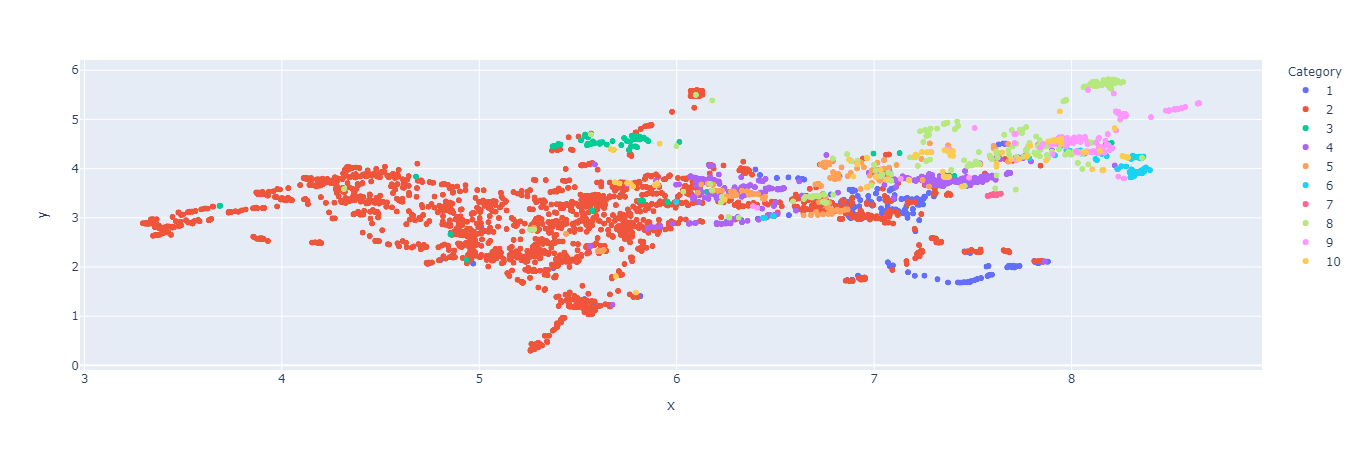

In [139]:
plot_df = df[["Category_0","Descr_cleaned", "Code", "Descr_cleaned_vectorized_low_dimension"]].copy()
plot_df['Category'] = plot_df['Category_0'].astype(str)
i=1
plot_df["x"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[2*i])
plot_df["y"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[2*i+1])

fig1 = scat(plot_df,['Descr_cleaned'])
fig1.update_layout()


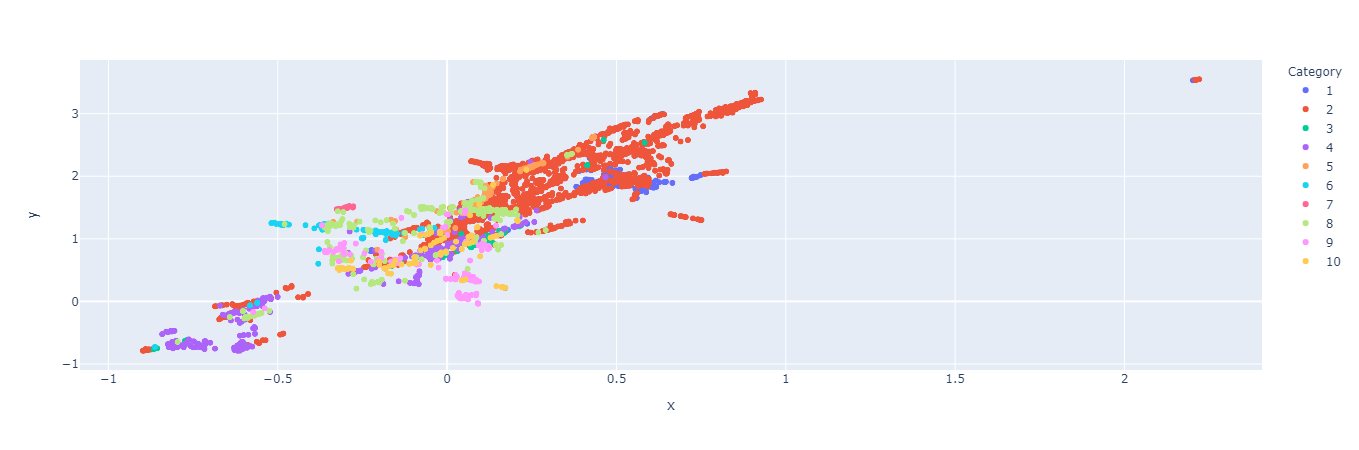

In [140]:
i=2
plot_df["x"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[2*i])
plot_df["y"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[2*i+1])
fig2 = scat(plot_df,['Descr_cleaned'])
fig2.update_layout()

### Clustering

In [141]:
df["label"] = text_processing.cluster(df.Descr_cleaned_vectorized_low_dimension)

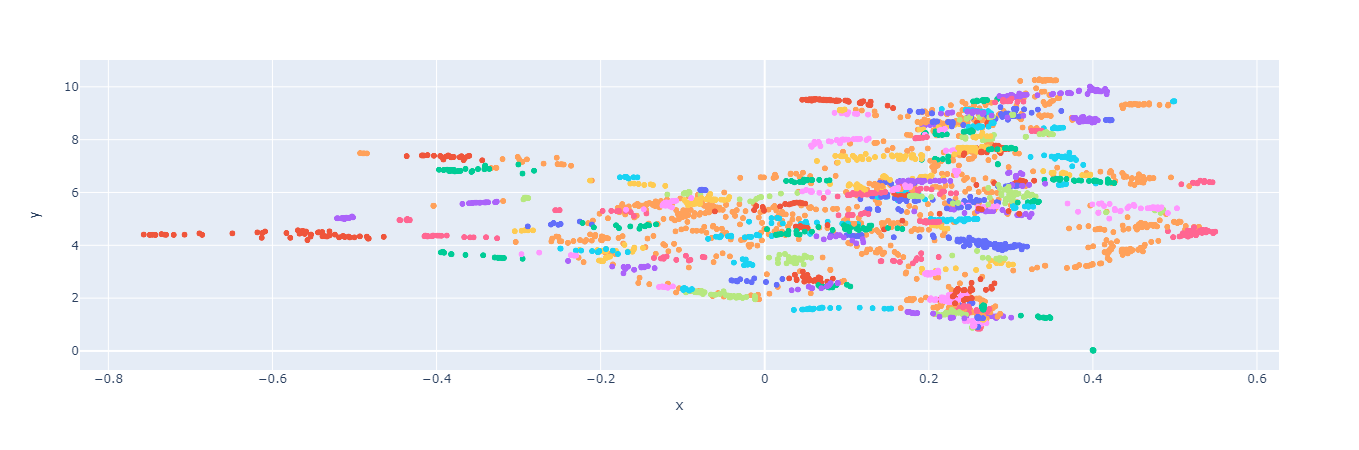

In [142]:
plot_df = df[["Category_0","Descr_cleaned", "Code", "Descr_cleaned_vectorized_low_dimension","label"]].copy()

plot_df["x"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[0])
plot_df["y"] = plot_df.Descr_cleaned_vectorized_low_dimension.apply(lambda x: x[1])
# add filtering
plot_df = plot_df[plot_df.x <3]

plot_df["Category"] = plot_df.label.astype(str)

fig1 = scat(plot_df, ['Descr_cleaned'])
fig1.update_layout(showlegend=False)

## Investigate the new categories

In [143]:
pd.set_option('display.max_colwidth', None)

In [144]:
plot_df = plot_df[plot_df["label"] == test_case.label.values[0]]

In [152]:
lab = 3
cols = ['Code','Descr_old','Descr_cleaned','label','Category_2']
test_case = df[df.label==lab]
display(HTML(f'<h3>These are all the items with label {lab}</h3>'), 
        test_case[cols])

cat = test_case.Category_2.values[0]
tmp = df[df.Category_2 == cat]
display(HTML(f'<h3>These are all the items with category {cat}</h3>'), 
tmp[cols].sort_values(by='label'))

# Now look at the clusters that intersect Category_2
labs = tmp.label.unique()
for l in labs:
    if l >=0:
        display(HTML(f'<h3>These are all the itms with label {l}</h3>'))
        display(df[df.label==l][cols].sort_values(by='Category_2'))

Code  \
3052  85.10.10   
3053  85.20.11   
3054  85.20.12   
3055  85.31.11   
3056  85.31.12   
3057  85.31.21   
3058  85.31.22   
3059  85.32.11   
3060  85.32.12   
3061  85.32.21   
3062  85.32.22   
3063  85.41.11   
3064  85.41.12   
3065  85.41.13   
3066  85.41.14   
3067  85.42.11   
3068  85.42.12   
3079  85.52.19   
3082  85.59.11   
3083  85.59.12   
3084  85.59.13   
3086  85.59.19   

                                                                            Descr_old  \
3052                                                   Pre-primary education services   
3053                                               On-line primary education services   
3054                                                 Other primary education services   
3055                               On-line general lower secondary education services   
3056                                 Other general lower secondary education services   
3057                               On-line general upper secondary education services   
3058                                 Other general upper secondary education services   
3059              On-line technical and vocational lower secondary education services   
3060                Other technical and vocational lower secondary education services   
3061              On-line technical and vocational upper secondary education services   
3062                Other technical and vocational upper secondary education services   
3063                   On-line post-secondary non-tertiary general education services   
3064                     Other post-secondary non-tertiary general education services   
3065  On-line post-secondary non-tertiary technical and vocational education services   
3066    Other post-secondary non-tertiary technical and vocational education services   
3067                                  On-line short-cycle tertiary education services   
3068                                    Other short-cycle tertiary education services   
3079                                                Other cultural education services   
3082                                                         Language school services   
3083                                                               IT school services   
3084                                             Vocational education services n.e.c.   
3086                                                        Education services n.e.c.   

                                                                    Descr_cleaned  \
3052                                               pre-primary education services   
3053                                           on-line primary education services   
3054                                                   primary education services   
3055                           on-line general lower secondary education services   
3056                                   general lower secondary education services   
3057                           on-line general upper secondary education services   
3058                                   general upper secondary education services   
3059              on-line technical vocational lower secondary education services   
3060                      technical vocational lower secondary education services   
3061              on-line technical vocational upper secondary education services   
3062                      technical vocational upper secondary education services   
3063               on-line post-secondary non-tertiary general education services   
3064                       post-secondary non-tertiary general education services   
3065  on-line post-secondary non-tertiary technical vocational education services   
3066          post-secondary non-tertiary technical vocational education services   
3067                              on-line short-cycle tertiary education services   
3068                                      short-cycle tertiary education services   
3079             

Code  \
3085  85.59.14   
3081  85.53.12   
3052  85.10.10   
3082  85.59.11   
3083  85.59.12   
3084  85.59.13   
3086  85.59.19   
3068  85.42.12   
3067  85.42.11   
3066  85.41.14   
3065  85.41.13   
3064  85.41.12   
3063  85.41.11   
3061  85.32.21   
3060  85.32.12   
3059  85.32.11   
3058  85.31.22   
3057  85.31.21   
3056  85.31.12   
3055  85.31.11   
3054  85.20.12   
3053  85.20.11   
3062  85.32.22   
3079  85.52.19   
3069  85.42.21   
3074  85.42.42   
3073  85.42.41   
3072  85.42.32   
3071  85.42.31   
3070  85.42.22   
3080  85.53.11   
3077  85.52.12   
3078  85.52.13   
3076  85.52.11   
3075  85.51.10   
3087  85.60.10   

                                                                            Descr_old  \
3085                                                      Home school support courses   
3081                                               Flying and sailing school services   
3052                                                   Pre-primary education services   
3082                                                         Language school services   
3083                                                               IT school services   
3084                                             Vocational education services n.e.c.   
3086                                                        Education services n.e.c.   
3068                                    Other short-cycle tertiary education services   
3067                                  On-line short-cycle tertiary education services   
3066    Other post-secondary non-tertiary technical and vocational education services   
3065  On-line post-secondary non-tertiary technical and vocational education services   
3064                     Other post-secondary non-tertiary general education services   
3063                   On-line post-secondary non-tertiary general education services   
3061              On-line technical and vocational upper secondary education services   
3060                Other technical and vocational lower secondary education services   
3059              On-line technical and vocational lower secondary education services   
3058                                 Other general upper secondary education services   
3057                               On-line general upper secondary education services   
3056                                 Other general lower secondary education services   
3055                               On-line general lower secondary education services   
3054                                                 Other primary education services   
3053                                               On-line primary education services   
3062                Other technical and vocational upper secondary education services   
3079                                                Other cultural education services   
3069               On-line bachelor's or equivalent level tertiary education services   
3074                   Other Doctoral or equivalent level tertiary education services   
3073                 On-line doctoral or equivalent level tertiary education services   
3072                   Other Master's or equivalent level tertiary education services   
3071                 On-line master's or equivalent level tertiary education services   
3070                 Other Bachelor's or equivalent level tertiary education services   
3080                                                      Car driving school services   
3077                                     Music schools and music instructors services   
3078                                  Fine arts schools and arts instruction services   
3076                                   Dancing schools and dance instructors services   
3075                                         Sports and recreation education services   
3087                                                     Educational support services   

                                                 

Code  \
3052  85.10.10   
3083  85.59.12   
3082  85.59.11   
3079  85.52.19   
3068  85.42.12   
3067  85.42.11   
3066  85.41.14   
3065  85.41.13   
3064  85.41.12   
3063  85.41.11   
3062  85.32.22   
3061  85.32.21   
3060  85.32.12   
3059  85.32.11   
3058  85.31.22   
3057  85.31.21   
3056  85.31.12   
3055  85.31.11   
3054  85.20.12   
3053  85.20.11   
3084  85.59.13   
3086  85.59.19   

                                                                            Descr_old  \
3052                                                   Pre-primary education services   
3083                                                               IT school services   
3082                                                         Language school services   
3079                                                Other cultural education services   
3068                                    Other short-cycle tertiary education services   
3067                                  On-line short-cycle tertiary education services   
3066    Other post-secondary non-tertiary technical and vocational education services   
3065  On-line post-secondary non-tertiary technical and vocational education services   
3064                     Other post-secondary non-tertiary general education services   
3063                   On-line post-secondary non-tertiary general education services   
3062                Other technical and vocational upper secondary education services   
3061              On-line technical and vocational upper secondary education services   
3060                Other technical and vocational lower secondary education services   
3059              On-line technical and vocational lower secondary education services   
3058                                 Other general upper secondary education services   
3057                               On-line general upper secondary education services   
3056                                 Other general lower secondary education services   
3055                               On-line general lower secondary education services   
3054                                                 Other primary education services   
3053                                               On-line primary education services   
3084                                             Vocational education services n.e.c.   
3086                                                        Education services n.e.c.   

                                                                    Descr_cleaned  \
3052                                               pre-primary education services   
3083                                                              school services   
3082                                                     language school services   
3079                                                  cultural education services   
3068                                      short-cycle tertiary education services   
3067                              on-line short-cycle tertiary education services   
3066          post-secondary non-tertiary technical vocational education services   
3065  on-line post-secondary non-tertiary technical vocational education services   
3064                       post-secondary non-tertiary general education services   
3063               on-line post-secondary non-tertiary general education services   
3062                      technical vocational upper secondary education services   
3061              on-line technical vocational upper secondary education services   
3060                      technical vocational lower secondary education services   
3059              on-line technical vocational lower secondary education services   
3058                                   general upper secondary education services   
3057                           on-line general upper secondary education services   
3056                                   general lower secondary education services   
3055             

Code  \
3069  85.42.21   
3070  85.42.22   
3071  85.42.31   
3072  85.42.32   
3073  85.42.41   
3074  85.42.42   

                                                               Descr_old  \
3069  On-line bachelor's or equivalent level tertiary education services   
3070    Other Bachelor's or equivalent level tertiary education services   
3071    On-line master's or equivalent level tertiary education services   
3072      Other Master's or equivalent level tertiary education services   
3073    On-line doctoral or equivalent level tertiary education services   
3074      Other Doctoral or equivalent level tertiary education services   

                                                       Descr_cleaned  label  \
3069  on-line bachelors equivalent level tertiary education services      4   
3070          bachelors equivalent level tertiary education services      4   
3071    on-line masters equivalent level tertiary education services      4   
3072            masters equivalent level tertiary education services      4   
3073   on-line doctoral equivalent level tertiary education services      4   
3074           doctoral equivalent level tertiary education services      4   

     Category_2  
3069         85  
3070         85  
3071         85  
3072         85  
3073         85  
3074         85

Code                                                Descr_old  \
3075  85.51.10                 Sports and recreation education services   
3139  91.02.10                                Museum operation services   
3151  93.11.10                       Sports facility operation services   
3152  93.12.10                                  Services of sport clubs   
3154  93.19.11  Sports and recreational sports event promotion services   
3156  93.19.13        Support services related to sports and recreation   
3157  93.19.19            Other sports and recreational sports services   

                                            Descr_cleaned  label Category_2  
3075                 sports recreation education services     54         85  
3139                            museum operation services     54         91  
3151                   sports facility operation services     54         93  
3152                                 services sport clubs     54         93  
3154  sports recreational sports event promotion services     54         93  
3156           support services related sports recreation     54         93  
3157                  sports recreational sports services     54         93

Code                                                   Descr_old  \
2910  74.20.23            Event photography and event videography services   
3076  85.52.11              Dancing schools and dance instructors services   
3077  85.52.12                Music schools and music instructors services   
3078  85.52.13             Fine arts schools and arts instruction services   
3129  90.01.10                              Services of performing artists   
3130  90.02.11  Performing arts event production and presentation services   
3131  90.02.12   Performing arts event promotion and organisation services   
3132  90.02.19                      Other performing arts support services   
3136  90.04.10                            Arts facility operation services   

                                               Descr_cleaned  label Category_2  
2910            event photography event videography services     53         74  
3076              dancing schools dance instructors services     53         85  
3077                music schools music instructors services     53         85  
3078             fine arts schools arts instruction services     53         85  
3129                             services performing artists     53         90  
3130  performing arts event production presentation services     53         90  
3131   performing arts event promotion organisation services     53         90  
3132                        performing arts support services     53         90  
3136                        arts facility operation services     53         90

Code  \
1853  30.99.10   
2419  49.32.12   
2424  49.39.31   
2439  49.41.20   
2474  51.10.20   
2479  51.21.20   
2491  52.21.24   
2530  55.90.13   
2949  77.39.14   
2947  77.39.12   
2946  77.39.11   
2945  77.35.10   
2944  77.34.10   
2943  77.33.12   
2942  77.33.11   
2935  77.29.13   
2940  77.31.10   
2938  77.29.16   
2950  77.39.19   
2931  77.21.10   
2930  77.12.19   
2929  77.12.11   
2941  77.32.10   
3080  85.53.11   

                                                                                                    Descr_old  \
1853                                                                         Other transport equipment n.e.c.   
2419                                                            Rental services of passenger cars with driver   
2424                                                         Rental services of buses and coaches with driver   
2439                                                                  Rental services of trucks with operator   
2474                                       Rental services of passenger air transport equipment with operator   
2479                                         Rental services of freight air transport equipment with operator   
2491                                                                                     Parking lot services   
2530                                               Sleeping car and similar services in other transport media   
2949                                              Rental and leasing services of telecommunications equipment   
2947                                                                Rental and leasing services of containers   
2946                                                         Rental and leasing services of railroad vehicles   
2945                                                   Rental and leasing services of air transport equipment   
2944                                                 Rental and leasing services of water transport equipment   
2943                                                                 Rental and leasing services of computers   
2942                      Rental and leasing services of office machinery and equipment (excluding computers)   
2935                                                       Rental and leasing services of musical instruments   
2940                                      Rental and leasing services of agricultural machinery and equipment   
2938                                    Rental and leasing services of do-it-yourself machinery and equipment   
2950  Rental and leasing services of other machinery and equipment without operator and tangible goods n.e.c.   
2931                                             Rental and leasing services of recreational and sports goods   
2930                             Rental and leasing services of other land transport equipment without driver   
2929                                   Rental and leasing services of goods transport vehicles without driver   
2941                Rental and leasing services of construction and civil engineering machinery and equipment   
3080                                                                              Car driving school services   

                                                                    Descr_cleaned  \
1853                                                          transport equipment   
2419                                        rental services passenger cars driver   
2424                                         rental services buses coaches driver   
2439                                              rental services trucks operator   
2474                   rental services passenger air transport equipment operator   
2479                     rental services freight air transport equipment operator   
2491                                                         parking lot services   
2530                                sleeping car simi

Code  \
166   01.61.10   
167   01.62.10   
185   02.40.10   
211   03.00.71   
212   03.00.72   
2513  52.29.20   
2665  62.02.30   
2993  81.10.10   
3008  82.19.13   
3087  85.60.10   

                                                               Descr_old  \
166                                  Support services to crop production   
167                                Support services to animal production   
185                                         Support services to forestry   
211                                          Support services to fishing   
212                                      Support services to aquaculture   
2513                        Other transportation support services n.e.c.   
2665                                       IT technical support services   
2993                                Combined facilities support services   
3008  Document preparation and other specialised office support services   
3087                                        Educational support services   

                                                 Descr_cleaned  label  \
166                           support services crop production     76   
167                         support services animal production     76   
185                                  support services forestry     76   
211                                   support services fishing     76   
212                               support services aquaculture     76   
2513                           transportation support services     76   
2665                                technical support services     76   
2993                      combined facilities support services     76   
3008  document preparation specialised office support services     76   
3087                              educational support services     76   

     Category_2  
166          01  
167          01  
185          02  
211          03  
212          03  
2513         52  
2665         62  
2993         81  
3008         82  
3087         85

#### Cluster comparison

In [146]:
text_processing.evaluate(df, "Category_2", "label")

2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,541 - text_processing - INFO - Are these labellings anything like each other?
2020-11-14 16:56:44,548 - text_processing - INFO - Adjusted rand score: 0.08571486260960455
2020-11-14 16:56:44,548 - 

No, no they are not.

#### Looking at a specific case

In [147]:
test

NameError: name 'test' is not defined

In [ ]:
# Why is Despicable Me 2 next to Spy films?
print(movies_df[movies_df.title == "Despicable Me 2"].overview.tolist())

In [18]:
# Villain? Criminal? 

# He's called Gru, GRU...

In [19]:
wv.most_similar("gru")

[('kgb', 0.6759157776832581),
 ('smersh', 0.5931000709533691),
 ('spetsnaz', 0.5695321559906006),
 ('nkgb', 0.5644126534461975),
 ('counterintelligence', 0.5616932511329651),
 ('rezident', 0.5581782460212708),
 ('nkvd', 0.5543013215065002),
 ('nkvd/nkgb', 0.5516831278800964),
 ('gugb', 0.5502406358718872),
 ('krechetnikov', 0.5455362796783447)]